In [310]:
import pandas as pd
import re
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danielhtoledo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words_en = set(stopwords.words('english'))

In [311]:
df = pd.read_csv('train.csv')

In [312]:
df['target'] = df['target'].map({1: 'real disaster', 0: 'not-real disaster'})

In [313]:
def funcion_preprocesamiento(texto):
    texto = re.sub(r'(#\w+)','',texto)

    texto = re.sub(r"(\w+:\/\/\S+)",'',texto)

    texto = re.sub(r'(@[A-Za-z0-9]+)','',texto)

    texto = re.sub(r'\\[A-Za-z0-9]{3}','',texto)
    texto = re.sub(r'\\n','',texto)
    texto = re.sub(r'\\','',texto)
    texto = re.sub(r'"','',texto)
    texto = re.sub(r"'",'',texto)
    texto = re.sub(r'[^\w\s]','',texto)
    texto= re.sub(r'amp','',texto)
    texto = texto.lower()
    texto = re.sub(r'([^A-Za-z \t])|(\d)','',texto)
    texto = word_tokenize(texto)
    texto = [palabra for palabra in texto if palabra not in stop_words_en]
    texto = [lemmatizer.lemmatize(palabra) for palabra in texto]
    texto = ' '.join(texto)
    return texto

In [314]:
df['clean_text'] = df['text'].apply(funcion_preprocesamiento)
final_reales = df[df['target'] == "real disaster"]['clean_text'].str.cat(sep=' ')
final_no_reales = df[df['target'] == "not-real disaster"]['clean_text'].str.cat(sep=' ')

<Axes: >

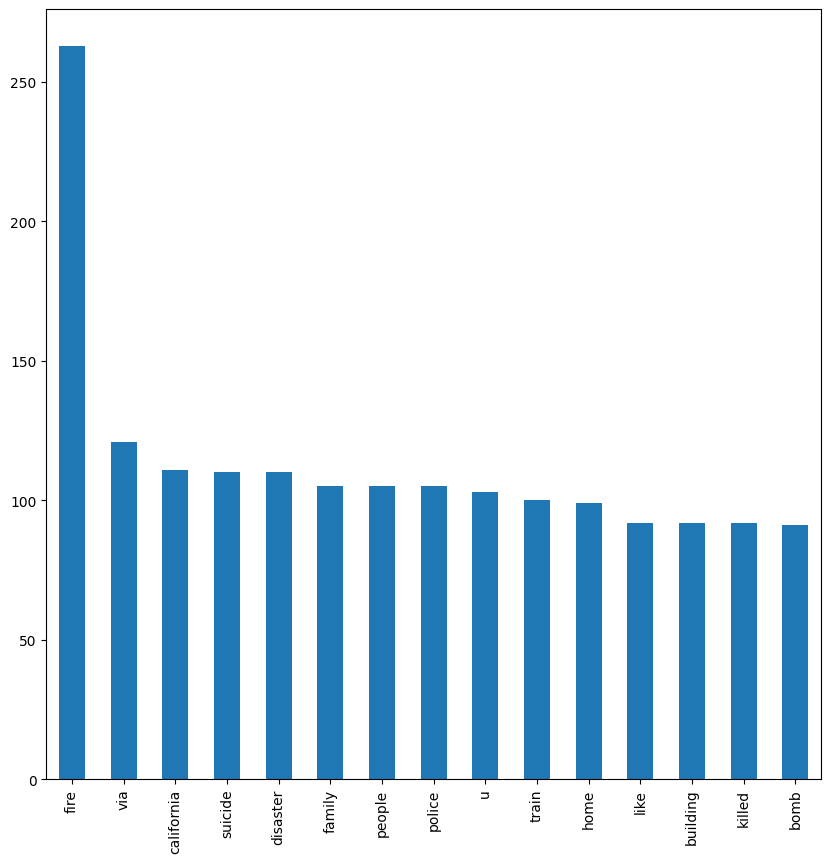

In [315]:
df[df['target'] == 'real disaster']['clean_text'].str.split(expand=True).stack().value_counts().head(15).plot(kind='bar', figsize=(10,10))

<Axes: >

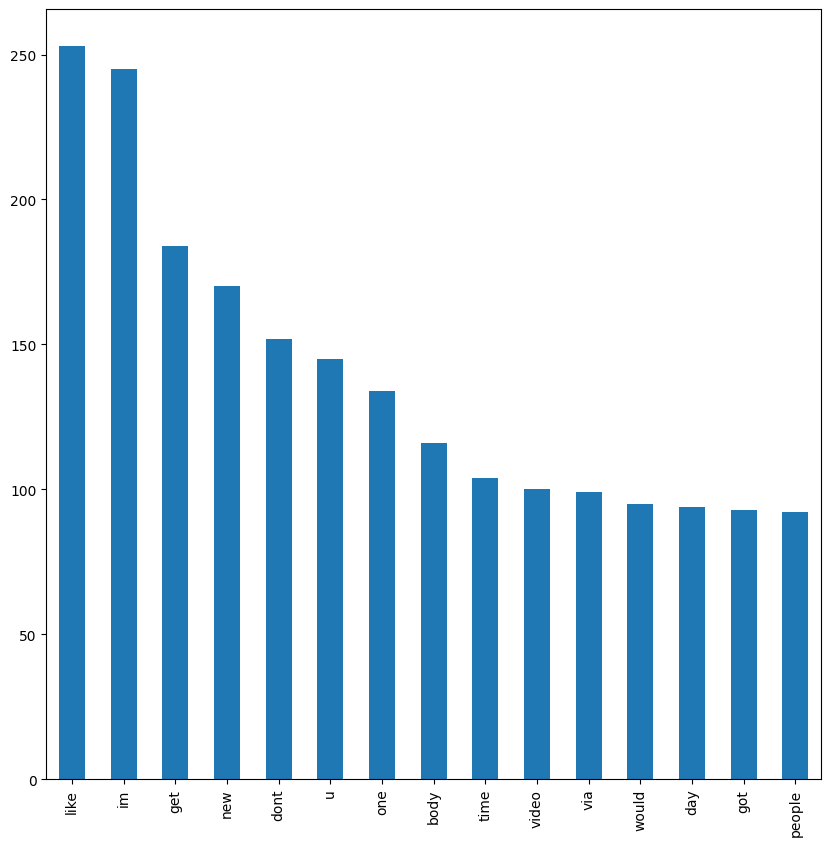

In [316]:
df[df['target'] == 'not-real disaster']['clean_text'].str.split(expand=True).stack().value_counts().head(15).plot(kind='bar', figsize=(10,10))

<Axes: >

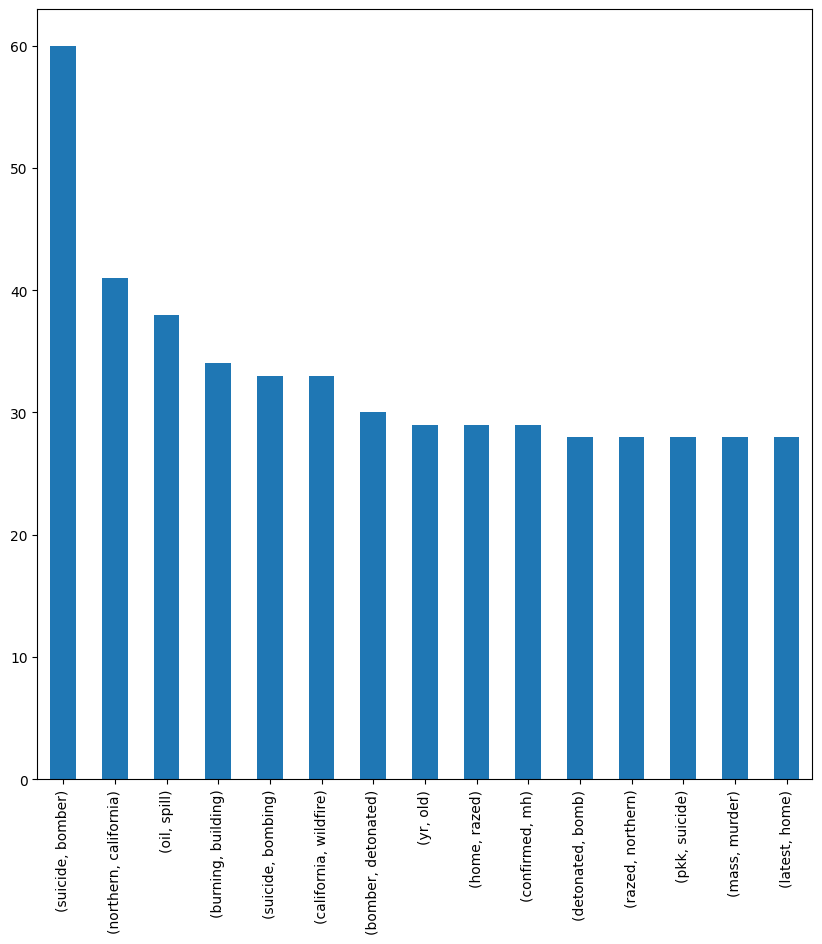

In [317]:
df[df['target'] == 'real disaster']['clean_text'].str.split().apply(nltk.bigrams).apply(pd.Series).stack().value_counts().head(15).plot(kind='bar', figsize=(10,10))

<Axes: >

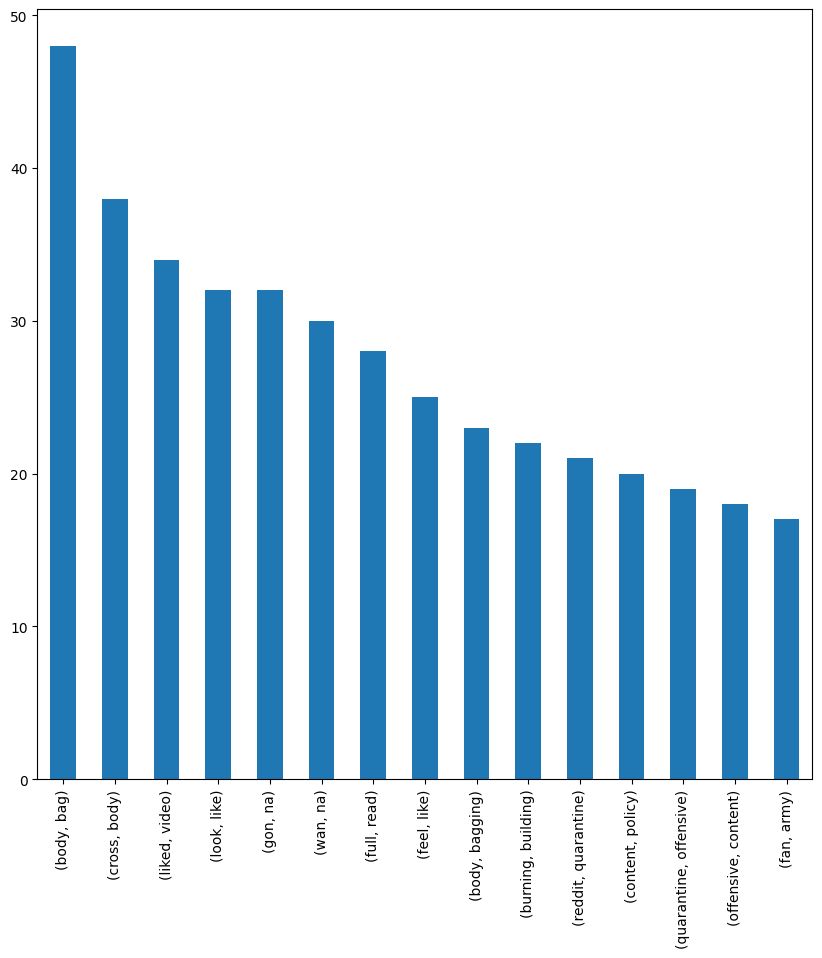

In [318]:
df[df['target'] == 'not-real disaster']['clean_text'].str.split().apply(nltk.bigrams).apply(pd.Series).stack().value_counts().head(15).plot(kind='bar', figsize=(10,10))

In [319]:
X = df["clean_text"]
y = df["target"]


X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.75)


tfif = TfidfVectorizer(ngram_range=(1,3))
x_train_vec = tfif.fit_transform(X_train)

x_test_vec= tfif.transform(X_test)

model = RandomForestClassifier(n_jobs=1, n_estimators=500, criterion='gini', bootstrap=False, min_samples_split=2, max_depth=100, min_samples_leaf=2)
model.fit(x_train_vec,y_train)



RandomForestClassifier(bootstrap=False, max_depth=100, min_samples_leaf=2,
                       n_estimators=500, n_jobs=1)

In [320]:
y_pred = model.predict(x_test_vec)

In [322]:
print(classification_report(y_test, y_pred))


                   precision    recall  f1-score   support

not-real disaster       0.72      0.92      0.81      3239
    real disaster       0.83      0.53      0.65      2471

         accuracy                           0.75      5710
        macro avg       0.78      0.72      0.73      5710
     weighted avg       0.77      0.75      0.74      5710



In [350]:


rf = RandomForestClassifier(random_state=82)


param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [ 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ["gini", "entropy", "log_loss"],
    'min_weight_fraction_leaf': [0.0, 0.01, 0.05]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, )


grid_search.fit(x_train_vec,y_train)

print("Mejores parámetros encontrados:", grid_search.best_params_)


Fitting 3 folds for each of 9720 candidates, totalling 29160 fits
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True,

In [359]:
# {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}

X = df["clean_text"]
y = df["target"]



X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.5)



tfif = TfidfVectorizer(ngram_range=(1,3))
x_train_vec = tfif.fit_transform(X_train)

x_test_vec= tfif.transform(X_test)

model = RandomForestClassifier( n_estimators=100, criterion='gini', bootstrap=False,  max_features= 'sqrt',min_samples_split=10, max_depth=None, min_samples_leaf=2, min_weight_fraction_leaf=0.0, random_state=82)
model.fit(x_train_vec,y_train)
y_pred = model.predict(x_test_vec)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

not-real disaster       0.78      0.84      0.81      2149
    real disaster       0.77      0.69      0.73      1658

         accuracy                           0.77      3807
        macro avg       0.77      0.77      0.77      3807
     weighted avg       0.77      0.77      0.77      3807



In [345]:


X = df["clean_text"]
y = df["target"]



X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.85)



tfif = TfidfVectorizer(ngram_range=(1,3))
x_train_vec = tfif.fit_transform(X_train)

x_test_vec= tfif.transform(X_test)

model = RandomForestClassifier(n_jobs=-1, n_estimators=100, criterion='entropy', bootstrap=False,  max_features= 'sqrt',min_samples_split=10, max_depth=None, min_samples_leaf=2, random_state=82)
model.fit(x_train_vec,y_train)
y_pred = model.predict(x_test_vec)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

not-real disaster       0.73      0.84      0.78      3666
    real disaster       0.74      0.59      0.66      2806

         accuracy                           0.73      6472
        macro avg       0.73      0.72      0.72      6472
     weighted avg       0.73      0.73      0.73      6472



In [343]:

train_sizes, train_scores, test_scores = learning_curve(model, x_train_vec, y_train,
                                                        cv=5, train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        n_jobs=-1, random_state=42)

# Calcular la media y desviación estándar de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


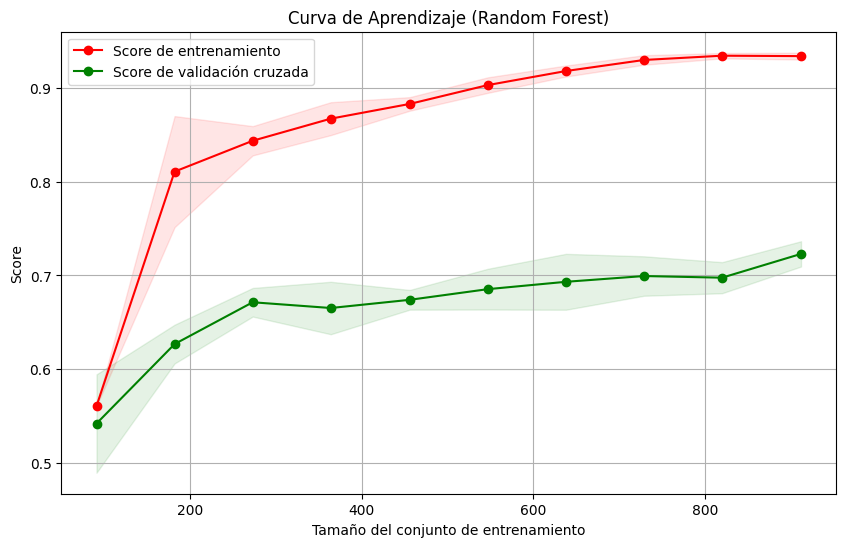

In [344]:
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizaje (Random Forest)")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score")
plt.grid()

# Área sombreada para la desviación estándar
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

# Puntuaciones medias
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score de entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validación cruzada")

# Leyenda y mostrar gráfica
plt.legend(loc="best")
plt.show()


In [450]:

X = df["clean_text"]
y = df["target"]



X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size = 0.85)



tfif = TfidfVectorizer(ngram_range=(1,3))
x_train_vec = tfif.fit_transform(X_train)

x_test_vec= tfif.transform(X_test)

model = LogisticRegressionCV(solver='liblinear', max_iter=100, random_state=82, fit_intercept=False, Cs=15)
model.fit(x_train_vec,y_train)
y_pred = model.predict(x_test_vec)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

not-real disaster       0.75      0.85      0.80      3683
    real disaster       0.76      0.63      0.69      2789

         accuracy                           0.76      6472
        macro avg       0.76      0.74      0.75      6472
     weighted avg       0.76      0.76      0.75      6472



In [451]:
from sklearn.ensemble import AdaBoostClassifier
model.fit(x_train_vec,y_train)
y_pred = model.predict(x_test_vec)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

not-real disaster       0.75      0.85      0.80      3683
    real disaster       0.76      0.63      0.69      2789

         accuracy                           0.76      6472
        macro avg       0.76      0.74      0.75      6472
     weighted avg       0.76      0.76      0.75      6472



In [463]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=100, max_depth=2)
model.fit(x_train_vec,y_train)
y_pred = model.predict(x_test_vec)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

not-real disaster       0.61      0.97      0.75      3683
    real disaster       0.83      0.16      0.27      2789

         accuracy                           0.62      6472
        macro avg       0.72      0.57      0.51      6472
     weighted avg       0.70      0.62      0.54      6472



<Axes: xlabel='target'>

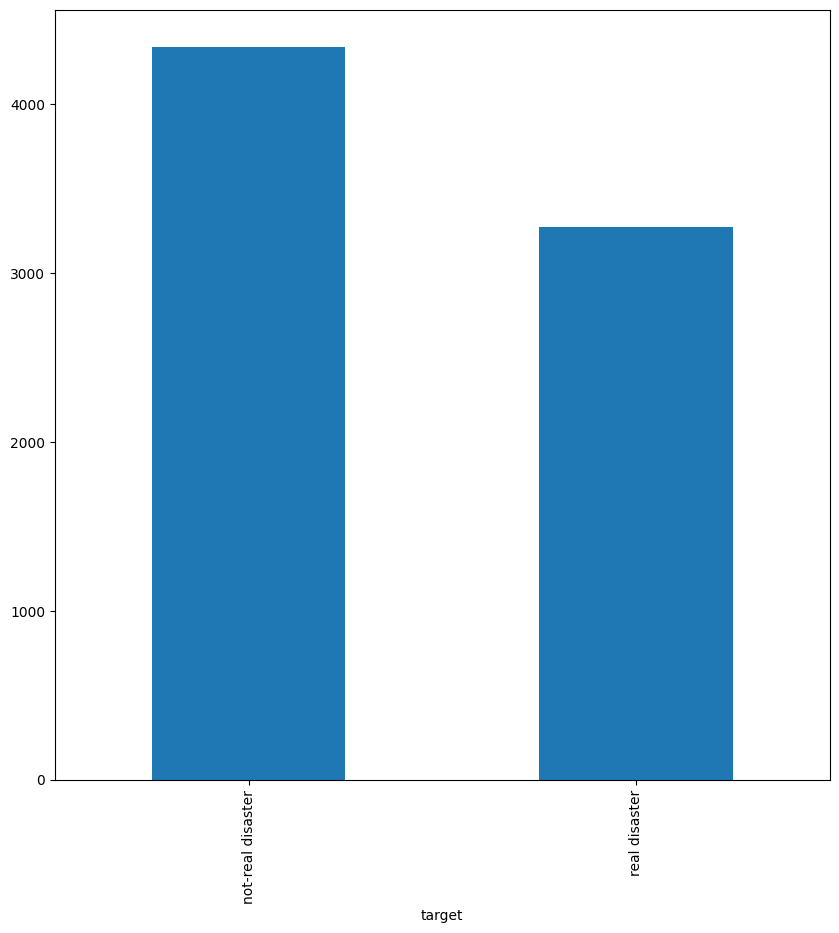

In [462]:
df["target"].value_counts().plot(kind='bar', figsize=(10,10))